In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape, BatchNormalization
from tensorflow.keras.layers import Input, concatenate, Activation, Conv2DTranspose, UpSampling2D
from tensorflow.keras.applications import VGG16, vgg16, ResNet50
import tensorflow.keras.backend as kb

import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import cv2
import scipy.io
from skimage import color

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from skimage.transform import resize

In [ ]:
!pip install scikit-image==0.17.2

     |████████████████████████████████| 12.4MB 9.7MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scikit-image 0.16.2
    Uninstalling scikit-image-0.16.2:
      Successfully uninstalled scikit-image-0.16.2


In [6]:
!pip install --upgrade opencv-python
!pip install --upgrade opencv-contrib-python

     |████████████████████████████████| 49.5MB 93kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.3.0.36
    Uninstalling opencv-python-4.3.0.36:
      Successfully uninstalled opencv-python-4.3.0.36


     |████████████████████████████████| 55.7MB 79kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [ ]:
!pip install matplotlib==3.3.1

     |████████████████████████████████| 11.6MB 6.6MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [ ]:
# Connect to TPU

print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.3.0


BaseException: ignored

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
(X_train_orig, y_train_orig), (X_test_orig, y_test_orig) = tf.keras.datasets.cifar10.load_data()

In [3]:
lab_train = color.rgb2lab(X_train_orig)
lab_test = color.rgb2lab(X_test_orig)

In [5]:
yuv_train = color.rgb2yuv(X_train_orig)
yuv_test = color.rgb2yuv(X_test_orig)

In [6]:
# gamut = np.load('/content/drive/MyDrive/Junior Year/COS 429 - Team Project/pts_in_hull.npy')
gamut = get_ab_bins(size=81)
nn = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(gamut)

24.444444444444443
[-110.          -85.55555556  -61.11111111  -36.66666667  -12.22222222
   12.22222222   36.66666667   61.11111111   85.55555556]
[[-110.0, -110.0], [-110.0, -85.55555555555556], [-110.0, -61.111111111111114], [-110.0, -36.66666666666667], [-110.0, -12.222222222222229], [-110.0, 12.222222222222214], [-110.0, 36.66666666666666], [-110.0, 61.111111111111086], [-110.0, 85.55555555555554], [-85.55555555555556, -110.0], [-85.55555555555556, -85.55555555555556], [-85.55555555555556, -61.111111111111114], [-85.55555555555556, -36.66666666666667], [-85.55555555555556, -12.222222222222229], [-85.55555555555556, 12.222222222222214], [-85.55555555555556, 36.66666666666666], [-85.55555555555556, 61.111111111111086], [-85.55555555555556, 85.55555555555554], [-61.111111111111114, -110.0], [-61.111111111111114, -85.55555555555556], [-61.111111111111114, -61.111111111111114], [-61.111111111111114, -36.66666666666667], [-61.111111111111114, -12.222222222222229], [-61.111111111111114, 

In [5]:
def get_ab_bins(size=64):
    if size == 313:
        bins = np.load('Data/pts_in_hull.npy')
        print(np.load('Data/prior_probs.npy'))
        return bins
    a = [-110, 110]
    b = [-110, 110]
    side = size ** 0.5
    stride = 220 / side
    print(stride)
    a_range = np.arange(a[0], b[1], stride)
    b_range = np.arange(a[0], b[1], stride)
    print(a_range)
    bins = []
    for aa in a_range:
        for bb in b_range:
            bins.append([aa, bb])
    print(bins)
    return np.array(bins)

In [ ]:
def get_uv_bins(size=100):
    u = [-0.5, 0.5]
    v = [-0.5, 0.5]
    side = size ** 0.5
    stride = 1 / side
    u_range = np.arange(u[0], v[1], stride)
    v_range = np.arange(u[0], v[1], stride)
    bins = []
    for uu in u_range:
        for vv in v_range:
            bins.append([uu, vv])
    print(bins)
    return np.array(bins)

In [8]:
def categorical_crossentropy_1hot(y_true, y_pred):
    q = 313
    # y_true = kb.reshape(y_true, (-1, 1))
    weights = kb.constant([32692.332, 11532.902, 2771.073, 605.7442, 1681.4673, 44785.54, 6297.0566, 2123.261, 814.7885, 530.36633, 327.4133, 283.70795, 1234.7217, 17054.824, 2514.61, 711.60846, 304.45456, 182.73027, 119.63076, 87.89746, 99.889915, 221.69066, 1341.28, 3814.037, 846.6636, 287.67728, 115.06888, 66.84124, 46.48236, 33.622704, 23.838528, 22.601885, 37.682274, 97.4023, 528.46124, 2064.901, 97.632, 36.90972, 27.697916, 18.81267, 13.949824, 10.060441, 6.568106, 5.218928, 6.635826, 13.080772, 39.560966, 221.5024, 7999.965, 1791.1654, 73.88461, 14.697856, 7.882602, 6.504739, 5.30758, 3.6577148, 2.2163224, 1.6621107, 1.8051032, 2.8322327, 6.497948, 20.946783, 106.1173, 2309.2488, 2036.9071, 61.83567, 9.721739, 4.2482567, 2.8006277, 2.2552273, 1.6711773, 1.1014158, 0.87275606, 0.88753355, 1.1489667, 2.0113451, 4.8732047, 14.188706, 41.108223, 290.12454, 69.43365, 7.7987857, 2.7812498, 1.6411736, 1.1473422, 0.8872179, 0.7398735, 0.66848093, 0.66865766, 0.7656106, 1.0837915, 2.0079954, 4.260345, 8.231727, 14.697401, 88.10616, 123.56377, 8.549213, 2.0607886, 1.0287431, 0.7337245, 0.58339643, 0.5325286, 0.5427769, 0.5741582, 0.63359207, 0.7972011, 1.2194233, 2.0938044, 3.4885461, 5.844843, 14.59768, 224.09665, 313.79123, 14.151388, 2.5179718, 1.0601915, 0.74090326, 0.6045285, 0.5248812, 0.50793827, 0.51475036, 0.5384855, 0.5965137, 0.7588944, 1.1414465, 1.8628801, 3.0509567, 5.4980116, 22.528412, 1018.6674, 1167.7639, 33.715576, 5.0022745, 1.8327619, 1.1583166, 0.9227692, 0.7416092, 0.5816683, 0.5300789, 0.5330327, 0.5488049, 0.5905039, 0.7108884, 1.0192196, 1.7134674, 3.1234066, 6.862162, 53.95567, 98.50841, 11.10202, 4.0598183, 2.4690924, 2.0525897, 1.9916863, 1.8360013, 1.2289033, 0.7950196, 0.6519397, 0.6305019, 0.6623881, 0.7775285, 1.072887, 1.799717, 3.5793085, 10.47319, 183.41864, 434.89355, 27.041687, 8.691425, 5.355047, 4.57398, 5.2476964, 6.054767, 4.988905, 3.1622958, 1.7259462, 1.0428593, 0.8667984, 0.87742054, 1.0143344, 1.3630986, 2.2221432, 4.5286417, 18.442816, 736.75616, 2796.7239, 78.949974, 17.526073, 10.9135475, 9.71835, 11.920596, 15.654068, 13.377048, 9.967241, 6.3578634, 3.727995, 2.1082728, 1.3659418, 1.1891056, 1.3834146, 1.8784806, 3.0373712, 6.474711, 40.62569, 3786.0413, 320.98657, 36.712803, 19.803667, 20.619112, 29.894442, 39.230774, 33.334198, 24.409525, 17.805473, 11.222572, 7.036376, 4.191616, 2.4527369, 1.647666, 1.5325255, 2.1887038, 4.0721583, 9.95364, 103.94156, 1869.3508, 95.62695, 37.57686, 41.439983, 77.08542, 105.08935, 90.82194, 61.963383, 44.418964, 30.049143, 19.298674, 13.181697, 8.7182665, 5.0008245, 2.9202373, 2.059343, 2.1413033, 4.296045, 15.0827055, 284.37225, 273.81094, 65.33963, 89.82112, 209.64352, 303.31833, 272.63504, 169.56891, 113.4218, 84.69019, 56.883522, 38.729336, 29.364346, 22.29629, 14.101571, 7.8442273, 4.777419, 3.5526936, 4.5467944, 18.035803, 676.8908, 215.30116, 163.6127, 449.10352, 715.139, 717.79974, 553.0553, 294.80643, 243.3219, 197.97186, 148.64093, 112.09155, 99.2456, 91.17506, 72.32096, 47.066765, 28.656807, 17.786356, 12.416392, 27.490313, 4218.1177, 3486.5208, 3318.3772, 2306.5361, 1566.8556, 680.7541, 546.5457, 564.2634, 642.14026, 767.8787, 753.0141, 960.2971, 1239.6636, 1434.2999, 1300.0032, 1000.7965, 648.57764, 315.42514, 436.99173, 263108.25, 43699.098, 5505.9375, 1138.0339, 2660.6387, 6030.845, 13213.201, 33383.035, 55437.87, 110139.055])

    y_true = kb.flatten(y_true)

    y_pred = kb.reshape(y_pred, (-1, q))
    weights = kb.gather(weights, y_true)
    weights = kb.reshape(weights, (-1, 1))

    y_pred *= weights
    loss = kb.sparse_categorical_crossentropy(y_true, y_pred)

    # print(kb.get_value(y_pred))
    # print(kb.shape(y_pred))

    return loss

In [9]:
def annealed_softmax(qab, temperature=0.38):
  expon = qab** (1/temperature)
  expon /= np.sum(expon, axis=-1, keepdims=True)
  
  return expon

def annealed_mean(qab, temperature=0.38):
  qab = annealed_softmax(qab, temperature)
  am = np.dot(qab, gamut)
  
  return am

In [10]:
def l2_rgb_loss(y_true, y_pred):
    """
    y_pred is the ab channels
    y_true is the rgb true image

    summary: converts y_pred to rgb and takes L2 loss
    """
    # # convert them both to numpy
    # y_true = y_true.numpy()
    # y_pred = y_pred.numpy()

    # # put the y_pred between 0 and 255 and get rgb version
    # y_pred = np.interp(y_pred, (y_pred.min(), y_pred.max()), (0, 255))
    # y_pred = color.yuv2rgb(y_pred)

    # R, G, B = yuv_to_rgb(y_pred)

    # diff = kb.square(y_true[:,:,:,0] - R)
    # diff += kb.square(y_true[:,:,:,1] - G)
    # diff += kb.square(y_true[:,:,:,2] - B)

    Y = y_pred[:,:,:,0]

    U = y_pred[:,:,:,1]
    V = y_pred[:,:,:,2]

    R = Y + 1.13983*V
    G = Y - 0.39465 * U - 0.58060 * V
    B = Y + 2.03211 * U

    y_pred = kb.stack((R,G,B), axis=-1)
    diff = kb.square(y_true - y_pred)

    return kb.mean(diff)

In [11]:
PATH = '/content/drive/MyDrive/Junior Year/COS 429 - Team Project/Models'
MODEL_TYPE = 'Classification/vgg_unlearnable_classification_rebal81_flipped1e3'

# with tpu_strategy.scope():
model = tf.keras.models.load_model(os.path.join(PATH, f"{MODEL_TYPE}.h5"), custom_objects={'categorical_crossentropy_1hot':categorical_crossentropy_1hot})

In [ ]:
PATH = '/content/drive/MyDrive/Junior Year/COS 429 - Team Project/Models'
MODEL_TYPE = 'Regression/vgg_lab_learnable'

# with tpu_strategy.scope():
model = tf.keras.models.load_model(os.path.join(PATH, f"{MODEL_TYPE}.h5"))

In [12]:
X_test = np.expand_dims(lab_test[:, :, :, 0], axis=-1)
y_test = X_test_orig

print(X_test.shape)
print(y_test.shape)

(10000, 32, 32, 1)
(10000, 32, 32, 3)


In [13]:
X_test = np.stack((X_test.squeeze(),)*3, axis=-1)

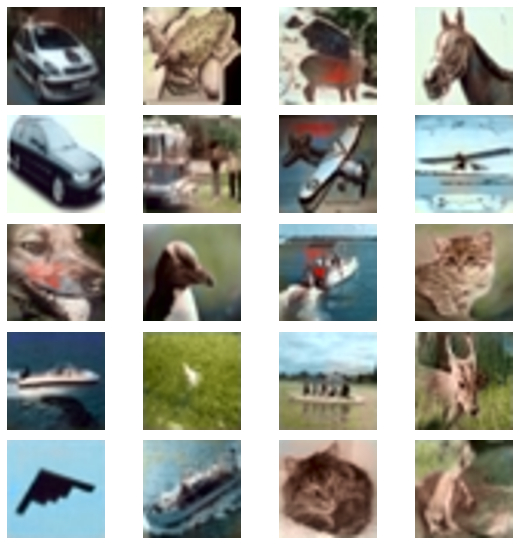

In [258]:
from PIL import Image

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5

a = 20
b = 1700
b = 8000
z = b

for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  
  im_in = np.expand_dims(X_test[i+z], axis=0)

  prediction = model.predict(im_in)
  prediction = annealed_mean(prediction)

  im_in = np.expand_dims(im_in[:,:,:,0], -1)
  prediction = np.concatenate((im_in, prediction), axis=-1)
  prediction = color.lab2rgb(prediction.squeeze())

  prediction = (prediction - np.min(prediction)) / (np.max(prediction) - np.min(prediction))
  prediction = Image.fromarray((prediction * 255).astype('uint8'), 'RGB')
  prediction = prediction.resize((128,128))

  plt.imshow(np.asarray(prediction))

  # plt.imshow(X_test[i], cmap='gray')

  plt.axis('off')

fig.tight_layout()  
plt.subplots_adjust(top=.94)
# fig.suptitle('Classification: 64 Bins w/LAB Loss Not Rebalanced', fontsize=16)
plt.show()
PATH = '/content/drive/MyDrive/Junior Year/COS 429 - Team Project/Outputs'
FILE = 'yuv_class'

# fig.savefig(os.path.join(PATH, FILE))

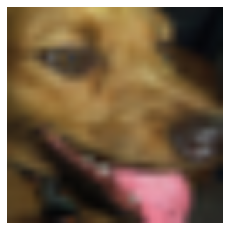

In [262]:
z = 8009

PATH = '/content/drive/MyDrive/Junior Year/COS 429 - Team Project/Bad Outputs'
TEMP = .38
fig=plt.figure(figsize=(3,3))
fig.add_subplot(1,1, 1)

im_in = np.expand_dims(X_test[z], axis=0)

prediction = model.predict(im_in)
prediction = annealed_mean(prediction, temperature=TEMP)

im_in = np.expand_dims(im_in[:,:,:,0], -1)
prediction = np.concatenate((im_in, prediction), axis=-1)
prediction = color.lab2rgb(prediction.squeeze())

# prediction = (prediction - np.min(prediction)) / (np.max(prediction) - np.min(prediction))
# prediction = Image.fromarray((prediction * 255).astype('uint8'), 'RGB')
# prediction = prediction.resize((128,128))
prediction = cv2.resize(prediction, (128, 128), cv2.INTER_CUBIC)

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.axis('off')

prediction = cv2.resize(np.asarray(X_test_orig[z] / 255), (128, 128), cv2.INTER_CUBIC)
plt.imshow(prediction)

plt.show()

fig.savefig(os.path.join(PATH, 'ground_8009.png'), bbox_inches = 'tight', pad_inches = 0)

In [ ]:
from PIL import Image

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5

a = 20
b = 1700
z = b

for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  
  im_in = np.expand_dims(X_test[i+z], axis=0)

  prediction = model.predict(im_in)
  prediction = annealed_mean(prediction)

  im_in = np.expand_dims(im_in[:,:,:,0], -1)
  prediction = np.concatenate((im_in, prediction), axis=-1)
  prediction = color.yuv2rgb(prediction.squeeze())

  prediction = (prediction - np.min(prediction)) / (np.max(prediction) - np.min(prediction))
  prediction = Image.fromarray((prediction * 255).astype('uint8'), 'RGB')
  prediction = prediction.resize((128,128))

  plt.imshow(np.asarray(prediction))

  # plt.imshow(X_test[i], cmap='gray')

  plt.axis('off')

fig.tight_layout()  
plt.subplots_adjust(top=.94)
fig.suptitle('Classification: 64 Bins w/LAB Loss Not Rebalanced', fontsize=16)
plt.show()

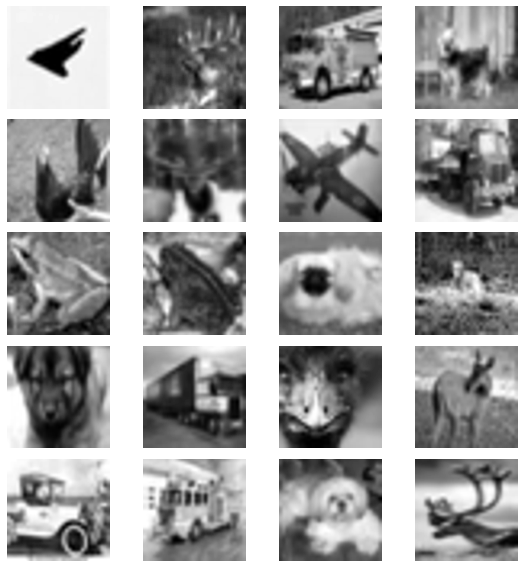

In [ ]:
from PIL import Image


# y_pred = model.predict(X_test[20:41])
PATH = '/content/drive/MyDrive/Junior Year/COS 429 - Team Project/Predictions'
FILE = 'grayscale'
# y_pred = np.load(f'{os.path.join(PATH,FILE)}.npy')

a = 20
b = 1700
z = a

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5

for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)

  # prediction = y_pred[i+z]
  # prediction = (prediction - np.min(prediction)) / (np.max(prediction) - np.min(prediction))

  prediction = X_test_orig[i+z][:,:,0] / 255

  prediction = Image.fromarray((prediction * 255).astype('uint8'), 'L')
  prediction = prediction.resize((128,128))

  plt.imshow(np.asarray(prediction), cmap='gray')

  plt.axis('off')

fig.tight_layout()  
# fig.suptitle('Regression: VGG Learnable Feature w/LAB Loss', fontsize=16)
plt.show()

PATH = '/content/drive/MyDrive/Junior Year/COS 429 - Team Project/Outputs'
FILE = f'{FILE}_{z}'

fig.savefig(os.path.join(PATH, FILE))

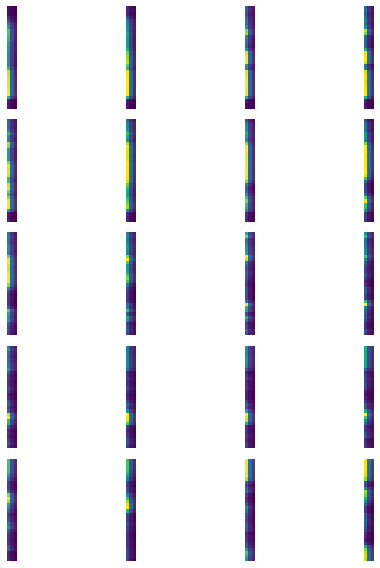

In [ ]:
y_pred = model.predict(X_test[20:41])

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5

for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)

  prediction = color.lab2rgb(y_pred[i])
  # prediction = color.yuv2rgb(y_pred[i])
  # prediction = y_pred[i]
  prediction = (prediction - np.min(prediction)) / (np.max(prediction) - np.min(prediction))

  # # classification pred
  # prediction = model.predict(y_pred[i].squeeze())
  # prediction = annealed_mean(prediction)
  # prediction = np.concatenate((im_in, prediction), axis=-1)
  # prediction = color.lab2rgb(prediction.squeeze())

  # prediction = (prediction - np.min(prediction)) / (np.max(prediction) - np.min(prediction))

  plt.imshow(prediction)

  plt.axis('off')

fig.tight_layout()  
plt.subplots_adjust(top=.94)
# fig.suptitle('Regression: VGG Learnable Feature w/LAB Loss', fontsize=16)
plt.show()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
prediction = color.lab2rgb(y_pred)
# prediction = color.yuv2rgb(y_pred)
# prediction = y_pred

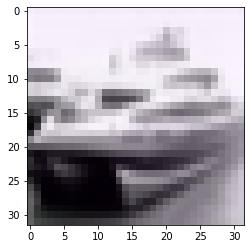

In [ ]:
plt.imshow(prediction[1])

In [ ]:
PATH = '/content/drive/MyDrive/Junior Year/COS 429 - Team Project/Predictions/'

with open(os.path.join(PATH, 'classification_vgg_learnable_norebal81.npy'), 'wb') as f:
    np.save(f, prediction)

In [ ]:
def AUC(im1, im2):
    diff = np.square(im1-im2)
    auc = np.zeros(256)
    for i in range(256):
        auc[i] += diff[diff<=i/2028].size
    return auc, np.sum(auc)/(im1.size*256)

In [ ]:
y_compare = y_test / 255

In [ ]:
PATH = '/content/drive/MyDrive/Junior Year/COS 429 - Team Project/Predictions/'

prediction = np.load(os.path.join(PATH, 'lab_conv.npy'))

In [ ]:
prediction = color.rgb2lab(prediction)

In [ ]:
y_compare = color.rgb2lab(y_compare)

In [ ]:
auc, area = AUC(y_compare, prediction)

print(area)

0.36319707157258063


In [ ]:
acc = (0.985423317082723- 0.9478383024851481) / (1 - 0.9478383024851481)

print(acc)

0.7205481490872379
